# Задание 3.2 - сверточные нейронные сети (CNNs) в PyTorch

Это упражнение мы буде выполнять в Google Colab - https://colab.research.google.com/  
Google Colab позволяет запускать код в notebook в облаке Google, где можно воспользоваться бесплатным GPU!  

Авторы курса благодарят компанию Google и надеятся, что праздник не закончится.

Туториал по настройке Google Colab:  
https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d  
(Keras инсталлировать не нужно, наш notebook сам установит PyTorch)


In [ ]:
# Intstall PyTorch and download data
!pip3 install torch torchvision

!wget -c http://ufldl.stanford.edu/housenumbers/train_32x32.mat http://ufldl.stanford.edu/housenumbers/test_32x32.mat

--2021-04-13 11:51:30--  http://ufldl.stanford.edu/housenumbers/train_32x32.mat
Resolving ufldl.stanford.edu (ufldl.stanford.edu)... 171.64.68.10
Connecting to ufldl.stanford.edu (ufldl.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182040794 (174M) [text/plain]
Saving to: ‘train_32x32.mat’

train_32x32.mat     100%[===================>] 173.61M  16.1MB/s    in 10s     

2021-04-13 11:51:41 (16.6 MB/s) - ‘train_32x32.mat’ saved [182040794/182040794]

--2021-04-13 11:51:41--  http://ufldl.stanford.edu/housenumbers/test_32x32.mat
Reusing existing connection to ufldl.stanford.edu:80.
HTTP request sent, awaiting response... 200 OK
Length: 64275384 (61M) [text/plain]
Saving to: ‘test_32x32.mat’

test_32x32.mat      100%[===================>]  61.30M  18.5MB/s    in 3.3s    

2021-04-13 11:51:44 (18.5 MB/s) - ‘test_32x32.mat’ saved [64275384/64275384]

FINISHED --2021-04-13 11:51:44--
Total wall clock time: 14s
Downloaded: 2 files, 235M in

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/assignment3')

Mounted at /content/drive


In [ ]:
from collections import namedtuple

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import transforms

In [ ]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

# Загружаем данные

In [ ]:
# First, lets load the dataset
data_train = dset.SVHN('/content/drive/MyDrive/Colab Notebooks/assignment1/data/', 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ])
                      )
data_test = dset.SVHN('/content/drive/MyDrive/Colab Notebooks/assignment1/data/', split='test', transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.43,0.44,0.47],
                                               std=[0.20,0.20,0.20])                           
                       ]))

Разделяем данные на training и validation.

На всякий случай для подробностей - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
validation_split = .2
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, 
                                           sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler)

In [ ]:
# We'll use a special helper module to shape it into a flat tensor
class Flattener(nn.Module):
    def forward(self, x):
        batch_size, *_ = x.shape
        return x.view(batch_size, -1)

Создадим простейшую сеть с новыми слоями:  
Convolutional - `nn.Conv2d`  
MaxPool - `nn.MaxPool2d`

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),    
            Flattener(),
            nn.Linear(64*2*2, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(nn_model.parameters(), lr=1e-1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=1)

Восстановите функцию `compute_accuracy` из прошлого задания.  
Единственное отличие в новом - она должна передать данные на GPU прежде чем прогонять через модель. Сделайте это так же, как это делает функция `train_model`

In [ ]:
def train_model(model, train_loader, val_loader,scheduler, loss, optimizer, num_epochs):    
    loss_history = []
    train_history = []
    val_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        for i_step, (x, y) in enumerate(train_loader):
          
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(x_gpu)    
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            correct_samples += torch.sum(indices == y_gpu)
            total_samples += y.shape[0]
            
            loss_accum += loss_value

        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        val_accuracy = compute_accuracy(model, val_loader)
        
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        val_history.append(val_accuracy)
        scheduler.step()
        print("Average loss: %f, Train accuracy: %f, Val accuracy: %f" % (ave_loss, train_accuracy, val_accuracy))
        
    return loss_history, train_history, val_history
        
def compute_accuracy(model, loader):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval() # Evaluation mode
    # DONE: Copy implementation from previous assignment
    # Don't forget to move the data to device before running it through the model!
    correct=0
    total=0
    for data in loader:
        x, labels = data
        x = x.to(device)
        labels=labels.to(device)
        outputs = model(x)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total





In [ ]:
loss_history, train_history, val_history = train_model(nn_model, train_loader, val_loader,scheduler, loss, optimizer, 5)

Average loss: 1.357109, Train accuracy: 0.547794, Val accuracy: 0.761859
Average loss: 0.700024, Train accuracy: 0.786762, Val accuracy: 0.805201
Average loss: 0.602330, Train accuracy: 0.820889, Val accuracy: 0.821241
Average loss: 0.547739, Train accuracy: 0.837679, Val accuracy: 0.800560
Average loss: 0.512744, Train accuracy: 0.848104, Val accuracy: 0.839943


# Аугментация данных (Data augmentation)

В работе с изображениями одним из особенно важных методов является аугментация данных - то есть, генерация дополнительных данных для тренировки на основе изначальных.   
Таким образом, мы получаем возможность "увеличить" набор данных для тренировки, что ведет к лучшей работе сети.
Важно, чтобы аугментированные данные были похожи на те, которые могут встретиться в реальной жизни, иначе польза от аугментаций уменьшается и может ухудшить работу сети.

С PyTorch идут несколько таких алгоритмов, называемых `transforms`. Более подробно про них можно прочитать тут -
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms

Ниже мы используем следующие алгоритмы генерации:
- ColorJitter - случайное изменение цвета
- RandomHorizontalFlip - горизонтальное отражение с вероятностью 50%
- RandomVerticalFlip - вертикальное отражение с вероятностью 50%
- RandomRotation - случайный поворот

In [ ]:
tfs = transforms.Compose([
    transforms.ColorJitter(hue=.50, saturation=.50),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(50, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# Create augmented train dataset
data_aug_train = dset.SVHN('/content/drive/MyDrive/Colab Notebooks/assignment1/data/', 
                       transform=tfs
                      )

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


Визуализируем результаты агментации (вообще, смотреть на сгенерированные данные всегда очень полезно).

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


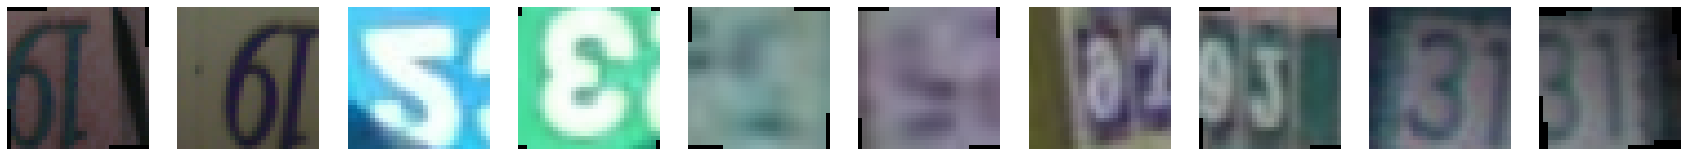

In [ ]:
# DOТУ: Visualize some augmented images!
# hint: you can create new datasets and loaders to accomplish this

# Based on the visualizations, should we keep all the augmentations?

tfs = transforms.Compose([
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
        
])

data_aug_vis = dset.SVHN('/content/drive/MyDrive/Colab Notebooks/assignment1/data/', 
                       transform=tfs
                      )

plt.figure(figsize=(30, 3))

for i, (x, y) in enumerate(data_aug_vis):
    if i == 10:
        break
    plt.subplot(1, 10, i+1)
    plt.grid(False)
    plt.imshow(x)
    plt.axis('off')

Все ли агментации одинаково полезны на этом наборе данных? Могут ли быть среди них те, которые собьют модель с толку?

Выберите из них только корректные

In [ ]:
# DONE: 
tfs = transforms.Compose([
    # DONE: Add good augmentations
    transforms.ColorJitter(hue=.20, saturation=.20),
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# DONE create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('/content/drive/MyDrive/Colab Notebooks/assignment1/data/', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
# Finally, let's train with augmentations!

# Note we shouldn't use augmentations on validation

loss_history, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader,scheduler, loss, optimizer, 5)

Average loss: 0.607809, Train accuracy: 0.814541, Val accuracy: 0.787523
Average loss: 0.574088, Train accuracy: 0.825786, Val accuracy: 0.837485
Average loss: 0.550358, Train accuracy: 0.832867, Val accuracy: 0.853935
Average loss: 0.534772, Train accuracy: 0.837474, Val accuracy: 0.851273
Average loss: 0.522300, Train accuracy: 0.842030, Val accuracy: 0.857416


# LeNet
Попробуем имплементировать классическую архитектуру сверточной нейронной сети, предложенную Яном ЛеКуном в 1998 году. В свое время она достигла впечатляющих результатов на MNIST, посмотрим как она справится с SVHN?
Она описана в статье ["Gradient Based Learning Applied to Document Recognition"](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf), попробуйте прочитать ключевые части и имплементировать предложенную архитетуру на PyTorch.

Реализовывать слои и функцию ошибки LeNet, которых нет в PyTorch, **не нужно** - просто возьмите их размеры и переведите в уже известные нам Convolutional, Pooling и Fully Connected layers.

Если в статье не очень понятно, можно просто погуглить LeNet и разобраться в деталях :)

In [ ]:
# DONE: Implement LeNet-like architecture for SVHN task
lenet_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(5,5), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5), stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            Flattener(),
            nn.Linear(64*5*5, 120),
            nn.ReLU(inplace=True),
            
		        nn.Linear(120, 60),
            nn.ReLU(inplace=True),
            
		        nn.Linear(60, 10),
          )

lenet_model.type(torch.cuda.FloatTensor)
lenet_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)
optimizer = optim.SGD(lenet_model.parameters(), lr=1e-1, weight_decay=1e-4)

In [ ]:
# Let's train it!
loss_history, train_history, val_history = train_model(lenet_model, train_aug_loader, val_loader,scheduler, loss, optimizer, 10)

Average loss: 1.443314, Train accuracy: 0.510528, Val accuracy: 0.804723
Average loss: 0.571033, Train accuracy: 0.829335, Val accuracy: 0.857416
Average loss: 0.471664, Train accuracy: 0.857114, Val accuracy: 0.865879
Average loss: 0.416940, Train accuracy: 0.876173, Val accuracy: 0.885332
Average loss: 0.382625, Train accuracy: 0.884142, Val accuracy: 0.881646
Average loss: 0.357541, Train accuracy: 0.893048, Val accuracy: 0.887380
Average loss: 0.337035, Train accuracy: 0.898543, Val accuracy: 0.893727
Average loss: 0.321830, Train accuracy: 0.902877, Val accuracy: 0.900348
Average loss: 0.307348, Train accuracy: 0.908235, Val accuracy: 0.904716
Average loss: 0.298731, Train accuracy: 0.909531, Val accuracy: 0.900075


# Подбор гиперпараметров

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(62),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=64, out_channels=12, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            Flattener(),
            nn.Linear(12*4*4, 120),
            nn.BatchNorm1d(120),
            nn.ReLU(inplace=True),
            
		        nn.Linear(120, 84),
            nn.BatchNorm1d(84),
            nn.ReLU(inplace=True),
            
		        nn.Linear(84, 10),
          )

nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

In [ ]:
# The key hyperparameters we're going to tune are learning speed, annealing rate and regularization
# We also encourage you to try different optimizers as well

Hyperparams = namedtuple("Hyperparams", ['learning_rate', 'anneal_epochs', 'reg'])
RunResult = namedtuple("RunResult", ['model', 'train_history', 'val_history', 'final_val_accuracy'])

learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
anneal_coeff = 0.9
anneal_epochs = [1,5]
reg = [1e-2,1e-3, 1e-4, 1e-5, 1e-7]

batch_size = 64
epoch_num = 5

# Record all the runs here
# Key should be Hyperparams and values should be RunResult
run_record = {} 

# Use grid search or random search and record all runs in run_record dictionnary 
# Important: perform search in logarithmic space!

# DONE: Your code here!


for i in range(len(reg)):
  for j in range(len(learning_rates)):
    for k in range(len(anneal_epochs)):
      anneal_epoch_temp=np.round(anneal_epochs[1]*np.random.random())
      optimizer = optim.Adam(nn_model.parameters(), lr=learning_rates[j], weight_decay=reg[i])
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epoch_temp, gamma=anneal_coeff)
      print(Hyperparams(learning_rates[j],anneal_epoch_temp,reg[i]))
      _, train_history, val_history = train_model(nn_model, train_aug_loader, val_loader,scheduler, loss, optimizer, epoch_num)

      run_record[Hyperparams(learning_rates[j],anneal_epoch_temp,reg[i])] = RunResult(nn_model,train_history,val_history,val_history[epoch_num-1])
      
print(run_record)



Hyperparams(learning_rate=0.01, anneal_epochs=4.0, reg=0.01)
Average loss: 0.978334, Train accuracy: 0.686653, Val accuracy: 0.745205
Average loss: 0.783125, Train accuracy: 0.759973, Val accuracy: 0.792642
Average loss: 0.772352, Train accuracy: 0.762652, Val accuracy: 0.748481
Average loss: 0.767163, Train accuracy: 0.764051, Val accuracy: 0.753873
Average loss: 0.740604, Train accuracy: 0.771525, Val accuracy: 0.768616
Hyperparams(learning_rate=0.01, anneal_epochs=5.0, reg=0.01)
Average loss: 0.746845, Train accuracy: 0.770826, Val accuracy: 0.752372
Average loss: 0.752537, Train accuracy: 0.769290, Val accuracy: 0.785339
Average loss: 0.748115, Train accuracy: 0.771406, Val accuracy: 0.748959
Average loss: 0.747315, Train accuracy: 0.768983, Val accuracy: 0.763975
Average loss: 0.744934, Train accuracy: 0.772003, Val accuracy: 0.734830
Hyperparams(learning_rate=0.001, anneal_epochs=2.0, reg=0.01)
Average loss: 0.562569, Train accuracy: 0.835409, Val accuracy: 0.866903
Average loss:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:372: RuntimeWarning: invalid value encountered in double_scalars
  if (self.last_epoch == 0) or (self.last_epoch % self.step_size != 0):


Average loss: 0.303015, Train accuracy: 0.909207, Val accuracy: 0.907583
Average loss: 0.302263, Train accuracy: 0.908781, Val accuracy: 0.905740
Average loss: 0.297891, Train accuracy: 0.910248, Val accuracy: 0.907174
Average loss: 0.300018, Train accuracy: 0.909122, Val accuracy: 0.907105
Average loss: 0.297556, Train accuracy: 0.911340, Val accuracy: 0.907924
Hyperparams(learning_rate=1e-05, anneal_epochs=3.0, reg=0.001)
Average loss: 0.292079, Train accuracy: 0.912808, Val accuracy: 0.909631
Average loss: 0.287724, Train accuracy: 0.913217, Val accuracy: 0.906081
Average loss: 0.289675, Train accuracy: 0.912125, Val accuracy: 0.909358
Average loss: 0.291616, Train accuracy: 0.912449, Val accuracy: 0.907242
Average loss: 0.290933, Train accuracy: 0.913524, Val accuracy: 0.908129
Hyperparams(learning_rate=1e-05, anneal_epochs=0.0, reg=0.001)
Average loss: 0.289788, Train accuracy: 0.914036, Val accuracy: 0.908197
Average loss: 0.289639, Train accuracy: 0.913268, Val accuracy: 0.90888

In [ ]:
best_val_accuracy = None
best_hyperparams = None
best_run = None

for hyperparams, run_result in run_record.items():
    if best_val_accuracy is None or best_val_accuracy < run_result.final_val_accuracy:
        best_val_accuracy = run_result.final_val_accuracy
        best_hyperparams = hyperparams
        best_run = run_result
        
print("Best validation accuracy: %4.2f, best hyperparams: %s" % (best_val_accuracy, best_hyperparams))
        

Best validation accuracy: 0.91, best hyperparams: Hyperparams(learning_rate=0.0001, anneal_epochs=4.0, reg=1e-07)


# Свободное упражнение - догоним и перегоним LeNet!

Попробуйте найти архитектуру и настройки тренировки, чтобы выступить лучше наших бейзлайнов.

Что можно и нужно попробовать:
- BatchNormalization (для convolution layers он в PyTorch называется [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d))
- Изменить количество слоев и их толщину
- Изменять количество эпох тренировки
- Попробовать и другие агментации

In [ ]:
# DONE: 
tfs = transforms.Compose([
    # DONE: Add good augmentations
    
    transforms.ColorJitter(hue=.20, saturation=.20),                        
    transforms.RandomApply((
    transforms.RandomRotation(10, resample=PIL.Image.BILINEAR),
    transforms.GaussianBlur(3),
    ),
    p=0.5),


    transforms.ToTensor(),
    transforms.Normalize(mean=[0.43,0.44,0.47],
                       std=[0.20,0.20,0.20])                           
])

# DONE create new instances of loaders with the augmentations you chose
data_aug_train = dset.SVHN('/content/drive/MyDrive/Colab Notebooks/assignment1/data/', 
                       transform=tfs
                      )
train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                           sampler=train_sampler)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1201: UserWarning: Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead
  "Argument resample is deprecated and will be removed since v0.10.0. Please, use interpolation instead"


In [ ]:
best_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=24, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            nn.Conv2d(in_channels=24, out_channels=64, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels=64, out_channels=42, kernel_size=(3,3), stride=1, padding=1),
            nn.BatchNorm2d(42),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            Flattener(),
            nn.Linear(42*8*8, 220),
            nn.BatchNorm1d(220),
            nn.ReLU(inplace=True),
            
		        nn.Linear(220, 110),
            nn.BatchNorm1d(110),
            nn.ReLU(inplace=True),

            nn.Linear(110, 46),
            nn.BatchNorm1d(46),
            nn.ReLU(inplace=True),
		        nn.Linear(46, 10),
          )

best_model.type(torch.cuda.FloatTensor)
best_model.to(device)

loss = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor)

# Финальный аккорд - проверим лучшую модель на test set

В качестве разнообразия - напишите код для прогона модели на test set вы.

В результате вы должны натренировать модель, которая покажет более **90%** точности на test set.  
Как водится, лучший результат в группе получит дополнительные баллы!

In [ ]:
batch_size = 64

data_size = data_train.data.shape[0]
_split = .2
split = int(np.floor(_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices)

validation_split = .1
test_split = .1



train_indices, _indices = indices[split:], indices[:split]
test_split = int(np.floor(test_split/(test_split+validation_split)*len(_indices)))

test_indices, val_indices = _indices[test_split:], _indices[:test_split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices) 

train_aug_loader = torch.utils.data.DataLoader(data_aug_train, batch_size=batch_size, 
                                         sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                       sampler=val_sampler)
test_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                       sampler=test_sampler)                                     

In [ ]:
  learning_rate = 0.0001
  anneal_coeff = 0.9
  anneal_epochs = 4
  reg = 1e-7


  epoch_num = 5

  optimizer = optim.Adam(best_model.parameters(), lr=learning_rate, weight_decay=reg)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)

  _, train_history, val_history = train_model(best_model, train_aug_loader, val_loader,scheduler, loss, optimizer, epoch_num)


Average loss: 1.450894, Train accuracy: 0.576630, Val accuracy: 0.834949
Average loss: 0.639242, Train accuracy: 0.840272, Val accuracy: 0.876451
Average loss: 0.455818, Train accuracy: 0.874126, Val accuracy: 0.892423
Average loss: 0.373800, Train accuracy: 0.893151, Val accuracy: 0.899522
Average loss: 0.322515, Train accuracy: 0.906460, Val accuracy: 0.903481


In [ ]:
  reg = 1e-3
  epoch_num = 5
  _, train_history, val_history = train_model(best_model, train_aug_loader, val_loader,scheduler, loss, optimizer, epoch_num)

Average loss: 0.289603, Train accuracy: 0.914394, Val accuracy: 0.907304
Average loss: 0.260524, Train accuracy: 0.924035, Val accuracy: 0.912628
Average loss: 0.237756, Train accuracy: 0.930502, Val accuracy: 0.912082
Average loss: 0.213769, Train accuracy: 0.938522, Val accuracy: 0.914812
Average loss: 0.200800, Train accuracy: 0.941269, Val accuracy: 0.912901


In [ ]:
# DONE Write the code to compute accuracy on test set

final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9163254163254163


In [ ]:
  learning_rate = 0.0001
  anneal_coeff = 0.9
  anneal_epochs = 4
  reg = 1e-03


  epoch_num = 5

  optimizer = optim.Adam(best_model.parameters(), lr=learning_rate, weight_decay=reg)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=anneal_epochs, gamma=anneal_coeff)

  _, train_history, val_history = train_model(best_model, train_aug_loader, val_loader,scheduler, loss, optimizer, epoch_num)


Average loss: 0.205689, Train accuracy: 0.940023, Val accuracy: 0.926153
Average loss: 0.198711, Train accuracy: 0.942412, Val accuracy: 0.926699
Average loss: 0.196237, Train accuracy: 0.942907, Val accuracy: 0.927382
Average loss: 0.192433, Train accuracy: 0.943845, Val accuracy: 0.928201
Average loss: 0.178112, Train accuracy: 0.949323, Val accuracy: 0.933251


In [ ]:
# DONE Write the code to compute accuracy on test set

final_test_accuracy = compute_accuracy(best_model, test_loader)
print("Final test accuracy - ", final_test_accuracy)

Final test accuracy -  0.9264163822525597
